# Problem Formulation

In its 2008 campaign, Obama's team experimented 24 combinations on the campaign webpage, in order to figure out which combination gave the highest sign up rate (number of clicks).

In the project, we do the same task: our objective is to figure out which combination/arm is best (i.e. gives most rewards) in the least time possible.

**Input**: You just choose which arm to pull.

**Interpretation of the output:**  
For the following output: {'Arm': '2', 'NetReward': 455, 'Pull': 30, 'Reward': 22}.
- Arm: The arm that you pulled. In this case, you pulled arm 2.
- Net Reward: The total reward up to the current pull. In this case, your total reward so fair is 455.
- Pull: How many times you have pulled. In this case, this is your 30th pull.
- Reward: Reward from current pull. In this case, your reward is 22/100. Each tim you pull the arm, the reward is between 0 and 100.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

In [11]:
import server_pull

In [12]:
# Check that server_pull.py is working 
output = server_pull.pull('user8','QkGstBxV',2)

In [13]:
print(output)

{'Arm': '2', 'NetReward': 1909977, 'Pull': 118732, 'Reward': 18}


## 0. Random Choices (Baseline)

In [14]:
# Initialize our recording of results
df = pd.DataFrame(np.zeros((24,3)), columns=['count','total_rewards','avg_rewards'], index=[k for k in range(1,25)]) # dataframe filled with zeros
df = df.astype(int)
base_reward_per_pull = []
series_of_arms = []

# Choose number of pulls
n = 1000

# Pull on arm randomly and add results to df
for i in range(n):
    # Pull an arm
    current_arm = np.random.randint(1,24)
    series_of_arms.append(current_arm)
        
    output = server_pull.pull('user8','QkGstBxV',current_arm)
    df['count'][current_arm] +=1
    df['total_rewards'][current_arm] += output['Reward']
    df['avg_rewards'][current_arm] = df['total_rewards'][current_arm]/df['count'][current_arm]
    base_reward_per_pull.append(output['Reward'])

In [15]:
df

,count,total_rewards,avg_rewards
1,52,695,13
2,38,661,17
3,43,545,12
4,50,343,6
5,46,616,13
6,47,1077,22
7,36,792,22
8,52,1002,19
9,44,462,10
10,47,653,13


In [7]:
total_pulls = sum(df['count'])
best_arm = df['avg_rewards'].argmax()+1 # As the arm was chosen randomly, the best arm is the one with the best average reward
print("The best arm after pulling {} times is {}".format(total_pulls, best_arm))
base_mean_reward_per_pull = sum(base_reward_per_pull)/n
print("The mean reward per pull for a random model = {}".format(base_mean_reward_per_pull))

The best arm after pulling 1000 times is 21
The mean reward per pull for a random model = 15.212


Text(0.5, 0, 'Step')

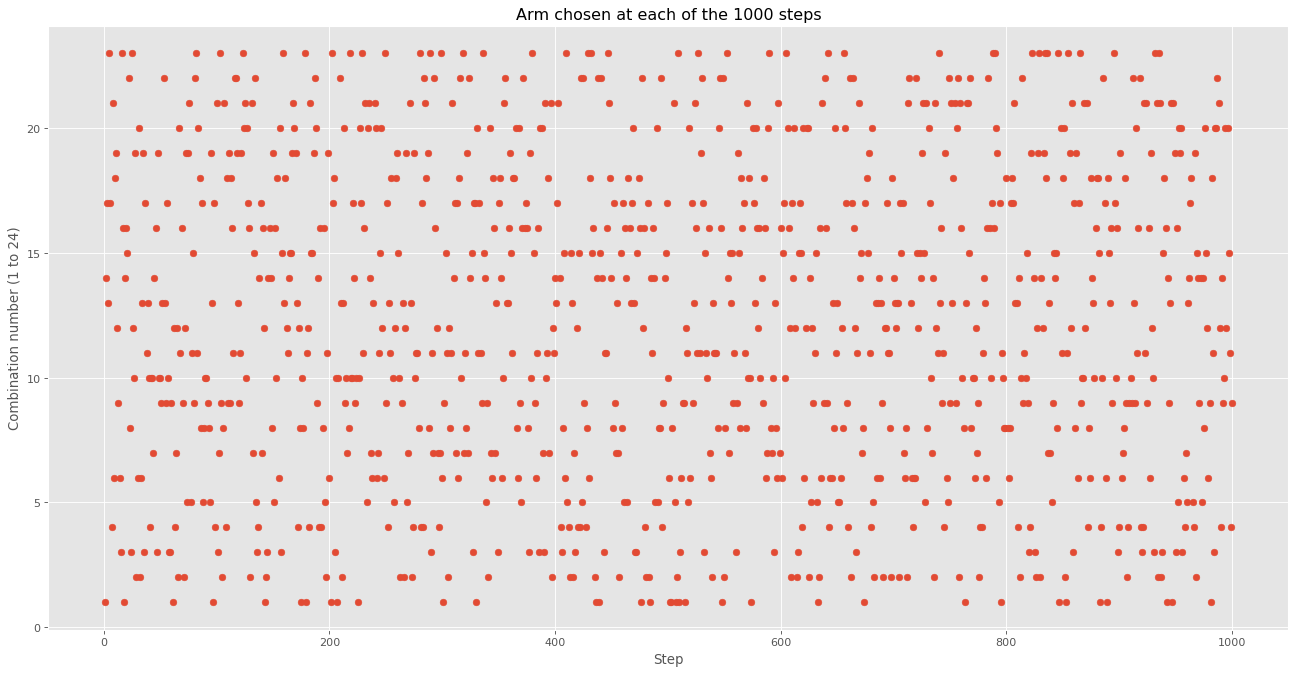

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)

plt.scatter(range(1,len(series_of_arms)+1),series_of_arms)
plt.title("Arm chosen at each of the {} steps".format(n))
plt.ylabel('Combination number (1 to 24)')
plt.xlabel('Step')

## 1. Epsilon-greedy

"Idea" of what the algorithm looks like:

```
Choose epsilon; # exploration probability  
Choose n; # number of iterations

for i = 1 to n:  
    p = pick a random number from 0 to 1  
    if p < epsilon:  
       current_bandit = pick bandit at random  # explore  
    else:  
       current_bandit = pick best bandit so far  # exploit  
    reward = current_bandit.pull_arm()  
    Update estimation for what rewards the current bandit gives
```



In [9]:
# Initialize our recording of results
df = pd.DataFrame(np.zeros((24,3)), columns=['count','total_rewards','avg_rewards'], index=[k for k in range(1,25)]) # dataframe filled with zeros
df = df.astype(int)
series_of_arms = []

# First, pull on arm randomly and add results to df
current_arm = np.random.randint(1,24)
output = server_pull.pull('user8','QkGstBxV',current_arm)
df['count'][current_arm] +=1
df['total_rewards'][current_arm] += output['Reward']
df['avg_rewards'][current_arm] = df['total_rewards'][current_arm]/df['count'][current_arm]
eps_reward_per_pull = [output['Reward']]

# Then apply the epsilon-greedy algorithm
eps = 0.1 # Explore (instead of exploiting) 10% of times
n = 1000

for i in range(n):
    p = np.random.random() # pick a random number from 0 to 1
    if p < eps:
        current_arm = np.random.randint(1,24) # pick arm at random (= explore)        
    else: 
        current_arm = df['avg_rewards'].argmax()+1 # pick best arm so far, ie arm with best average reward (= exploit)
    
    series_of_arms.append(current_arm)
    # Add results to df
    output = server_pull.pull('user8','QkGstBxV',current_arm)
    df['count'][current_arm] +=1
    df['total_rewards'][current_arm] += output['Reward']
    df['avg_rewards'][current_arm] = df['total_rewards'][current_arm]/df['count'][current_arm]
    eps_reward_per_pull.append(output['Reward'])


In [10]:
df

,count,total_rewards,avg_rewards
1,3,28,9
2,5,82,16
3,6,93,15
4,6,36,6
5,3,34,11
6,7,136,19
7,8,191,23
8,4,73,18
9,3,29,9
10,2,33,16


In [11]:
total_pulls = sum(df['count'])
best_arm = df['avg_rewards'].argmax()+1 # As the arm was chosen randomly during exploration, the best arm is the one with the best average reward
print("The best arm after pulling {} times is {}".format(total_pulls, best_arm))
eps_mean_reward_per_pull = sum(eps_reward_per_pull)/(n+1)
print("The mean reward per pull for epsilon-greedy algorithm = {}".format(eps_mean_reward_per_pull))

The best arm after pulling 1001 times is 21
The mean reward per pull for epsilon-greedy algorithm = 23.322677322677322


Text(0.5, 0, 'Step')

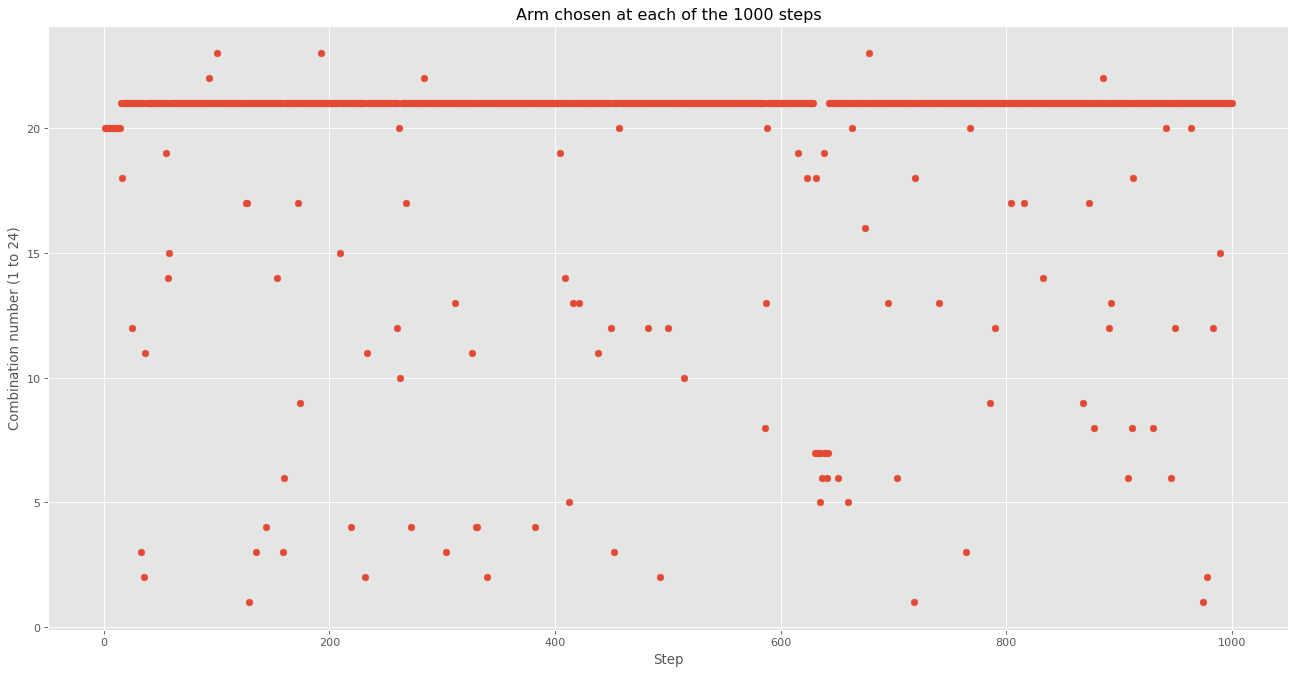

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)

plt.scatter(range(1,len(series_of_arms)+1),series_of_arms)
plt.title("Arm chosen at each of the {} steps".format(n))
plt.ylabel('Combination number (1 to 24)')
plt.xlabel('Step')

## 2. Bayesian Thompson Sampling

In [19]:
rewards=pd.DataFrame()

In [20]:
df[:2].mean()

0     17.5
1     11.0
2     19.5
3     13.5
4      7.0
5     16.0
6     26.0
7     27.0
8     21.5
9      9.0
10    13.5
11    12.5
12     8.5
13    11.0
14    20.0
15     6.5
16    19.5
17    19.5
18    16.5
19    13.0
20    22.0
21    24.0
22    19.5
23     9.5
dtype: float64

In [21]:
df[:2].describe().loc['max']

0     18.0
1     12.0
2     23.0
3     17.0
4      8.0
5     19.0
6     30.0
7     30.0
8     24.0
9      9.0
10    15.0
11    14.0
12     9.0
13    11.0
14    23.0
15     8.0
16    21.0
17    20.0
18    18.0
19    16.0
20    22.0
21    25.0
22    23.0
23    13.0
Name: max, dtype: float64

In [22]:
import random

In [23]:
##version1
N = 1000                    
d = 24           
max_reward=max(df.describe().loc['max'])
arms_selected = []     
series_of_arms = []
numbers_of_rewards_1 = [0] * d 
numbers_of_rewards_0 = [0] * d
total_reward = 0    
rewards=[]
regret=[]
for n in range(0, N):      
    arm = 0
    value=0
    Q=0
    max_random = 0
    max_reward=max(df.loc[n,:])
    for i in range(0, d):   
        #Beta distribution
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1) 
        if random_beta > max_random: 
            max_random = random_beta
            arm = i
    arms_selected.append(arm)
    series_of_arms.append(arm)
    reward = df.values[n, arm] 
    regret.append(max_reward-reward)
    max_mean_reward=max(df[:n+1].mean())
    if reward >= max_mean_reward:
        numbers_of_rewards_1[arm] = numbers_of_rewards_1[arm] + 1
    else:
        numbers_of_rewards_0[arm] = numbers_of_rewards_0[arm] + 1
    total_reward = total_reward + reward
print(total_reward)

21971


In [24]:
reward

27

In [25]:
# Count the number of selections
selection = {}
for key in arms_selected:
    selection[key] = selection.get(key, 0) + 1

In [26]:
selection

{22: 15,
 14: 15,
 19: 8,
 2: 12,
 21: 456,
 23: 9,
 11: 9,
 9: 9,
 17: 27,
 3: 9,
 16: 23,
 13: 10,
 18: 9,
 7: 140,
 1: 7,
 12: 8,
 15: 9,
 0: 9,
 4: 10,
 5: 9,
 10: 8,
 20: 12,
 8: 42,
 6: 135}

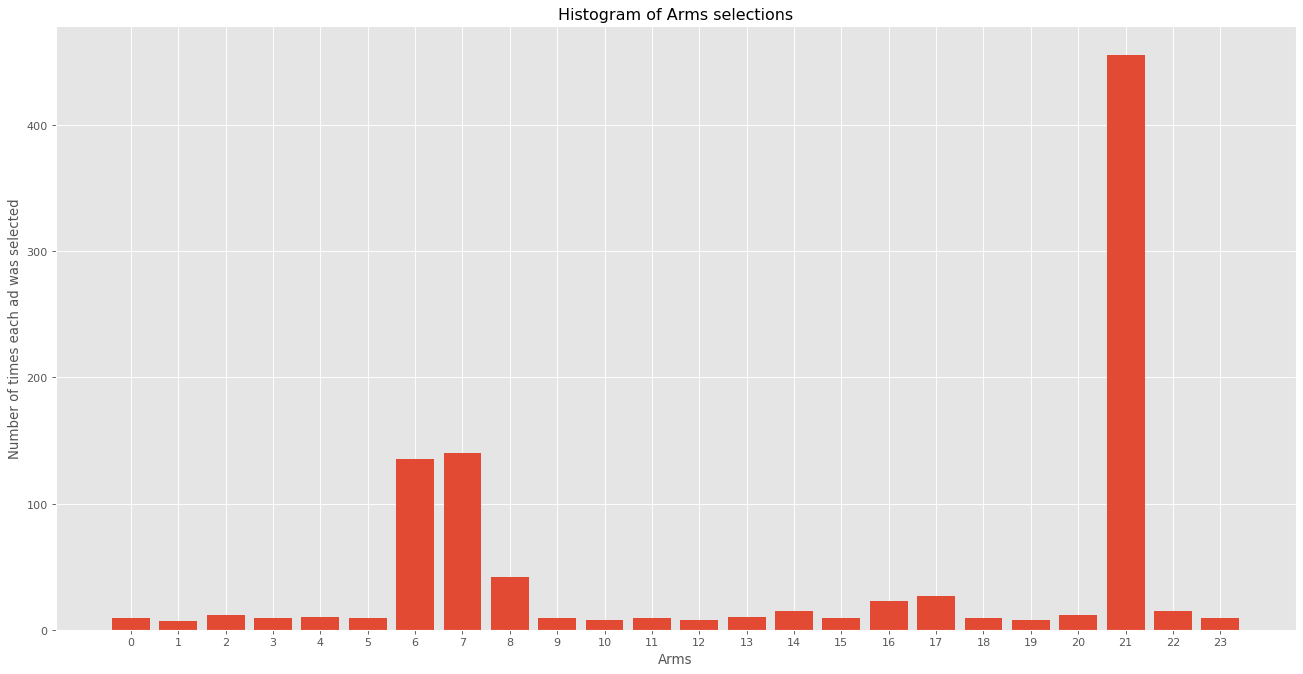

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)

num_list=sorted(selection.keys())
num=[selection[i] for i in num_list]
plt.bar(num_list,num,tick_label=num_list)
plt.title("Histogram of Arms selections")
plt.xlabel("Arms")
plt.ylabel("Number of times each ad was selected")
plt.show()

Text(0.5, 0, 'Step')

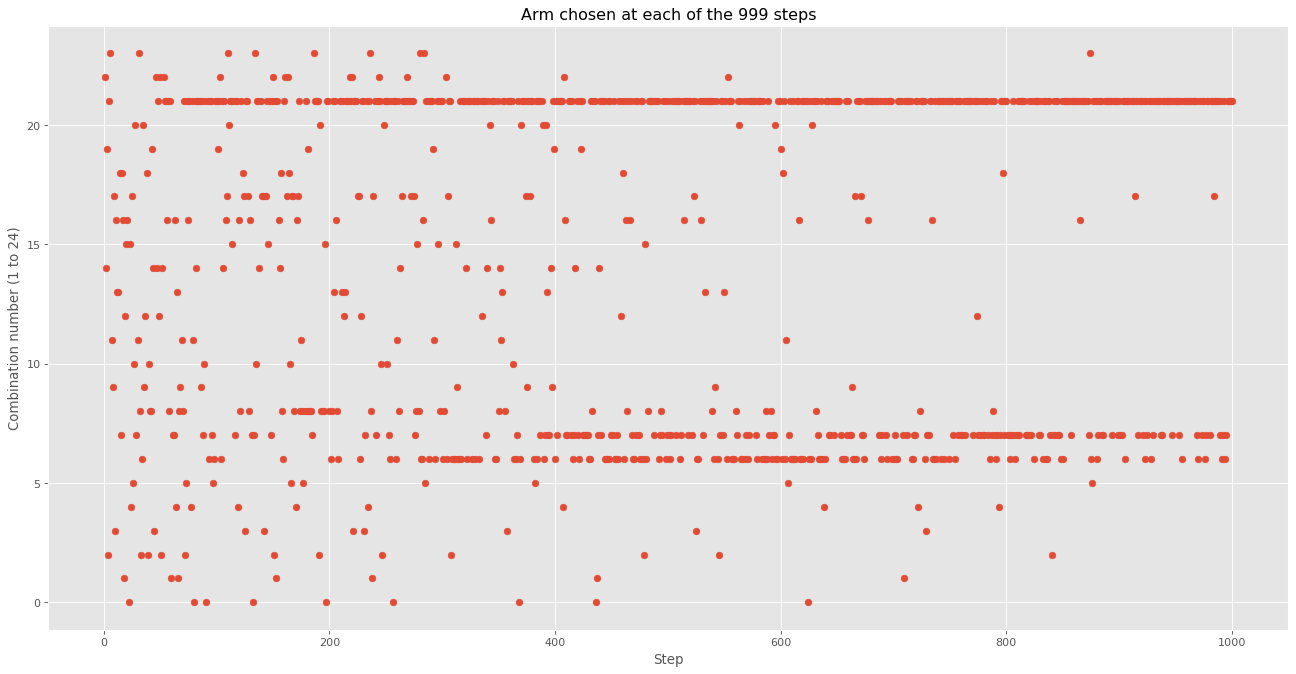

In [28]:
figure(figsize=(20, 10), dpi=80)

plt.scatter(range(1,len(series_of_arms)+1),series_of_arms)
plt.title("Arm chosen at each of the {} steps".format(n))
plt.ylabel('Combination number (1 to 24)')
plt.xlabel('Step')

##  3. Upper Confidence Bound

The idea of the algorithm is the following:

```
Choose n # number of iterations
Initialisation step. # for UCB1 & UCB1-Tuned we play each bandit once
for i = 1 to n do:
  current_bandit = pick bandit with greatest upper confidence index
  reward = current_bandit.pull_arm()  
  Update upper confidence index for current_bandit
  
```

In [13]:
# Choose 1000 records from results
#df=pd.DataFrame(np.zeros((700,24)),columns=[i for i in range(0,24)])
#for x in range(700):
#    for y in range(0,24):
#        df.loc[x,y]=server_pull.pull('user8','QkGstBxV',y)['Reward']

In [14]:
df=pd.read_excel('df.xlsx')

In [15]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,18.272000,13.146000,17.116000,12.316000,7.151000,13.368000,22.861000,23.11700,20.819000,10.090000,...,20.684000,5.802000,19.379000,21.970000,17.060000,13.023000,18.458000,24.360000,19.733000,7.833000
std,3.938976,3.459285,3.939043,3.224988,2.618598,3.342117,4.178892,4.21225,4.035657,2.914514,...,3.969875,2.325555,3.895964,4.175228,3.724281,3.284701,3.753975,4.178739,3.877725,2.625262
min,6.000000,3.000000,6.000000,4.000000,0.000000,4.000000,11.000000,9.00000,6.000000,2.000000,...,8.000000,0.000000,5.000000,8.000000,7.000000,3.000000,7.000000,12.000000,9.000000,1.000000
25%,15.000000,11.000000,14.000000,10.000000,5.000000,11.000000,20.000000,20.00000,18.000000,8.000000,...,18.000000,4.000000,17.000000,19.000000,14.000000,11.000000,16.000000,21.000000,17.000000,6.000000
50%,18.000000,13.000000,17.000000,12.000000,7.000000,13.000000,23.000000,23.00000,21.000000,10.000000,...,21.000000,6.000000,19.000000,22.000000,17.000000,13.000000,18.000000,24.000000,20.000000,8.000000
75%,21.000000,15.000000,20.000000,14.000000,9.000000,16.000000,26.000000,26.00000,23.000000,12.000000,...,23.000000,7.000000,22.000000,24.000000,19.000000,15.000000,21.000000,27.000000,22.000000,10.000000
max,32.000000,26.000000,29.000000,22.000000,16.000000,24.000000,38.000000,40.00000,33.000000,20.000000,...,35.000000,14.000000,31.000000,37.000000,29.000000,26.000000,30.000000,39.000000,30.000000,17.000000


In [16]:
import math
N = 1000
d = 24 # Number of combinations
series_of_arms = []
arms_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d
total_reward = 0

for n in range(0, N):
    arm = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            arm = i
    arms_selected.append(arm)
    series_of_arms.append(arm)
    numbers_of_selections[arm] = numbers_of_selections[arm] + 1
    reward = df.values[n, arm] 
    sums_of_rewards[arm] = sums_of_rewards[arm] + reward
    total_reward = total_reward + reward

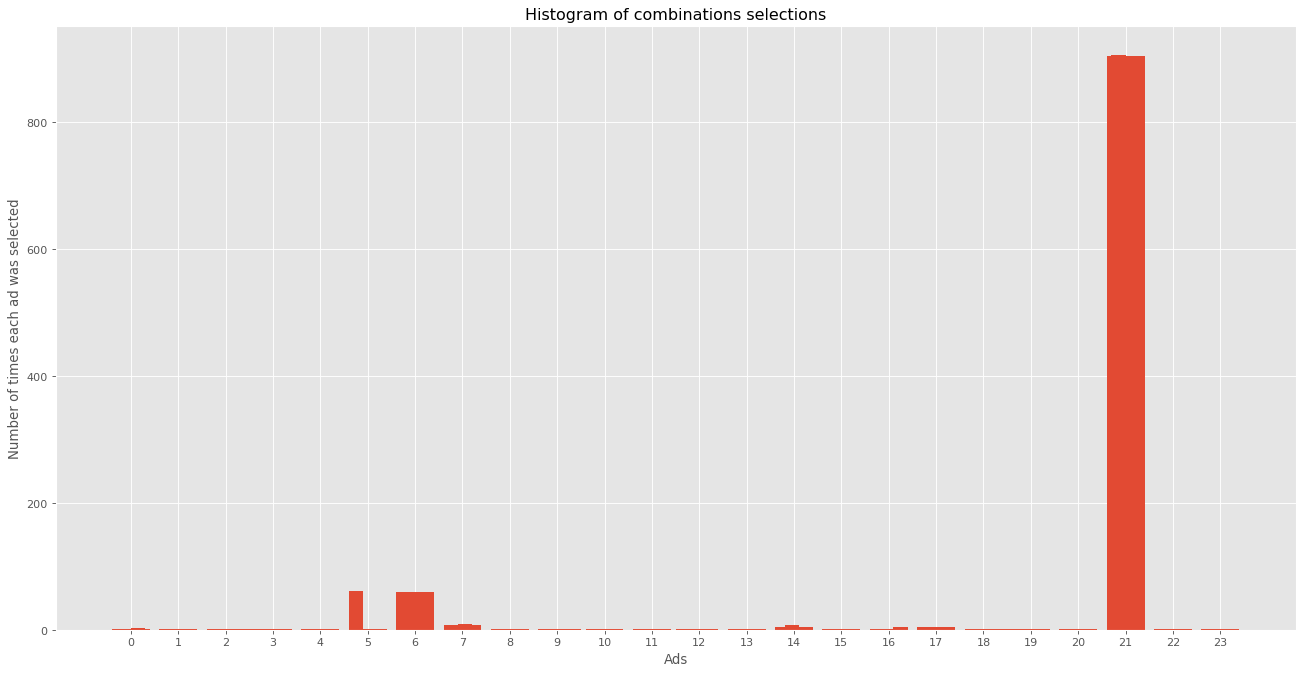

In [17]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)

plt.hist(arms_selected, width=0.3)

# Count the number of selections
selection = {}
for key in arms_selected:
    selection[key] = selection.get(key, 0) + 1

num_list=sorted(selection.keys())
num=[selection[i] for i in num_list]

plt.bar(num_list,num,tick_label=num_list)
plt.title('Histogram of combinations selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

Text(0.5, 0, 'Step')

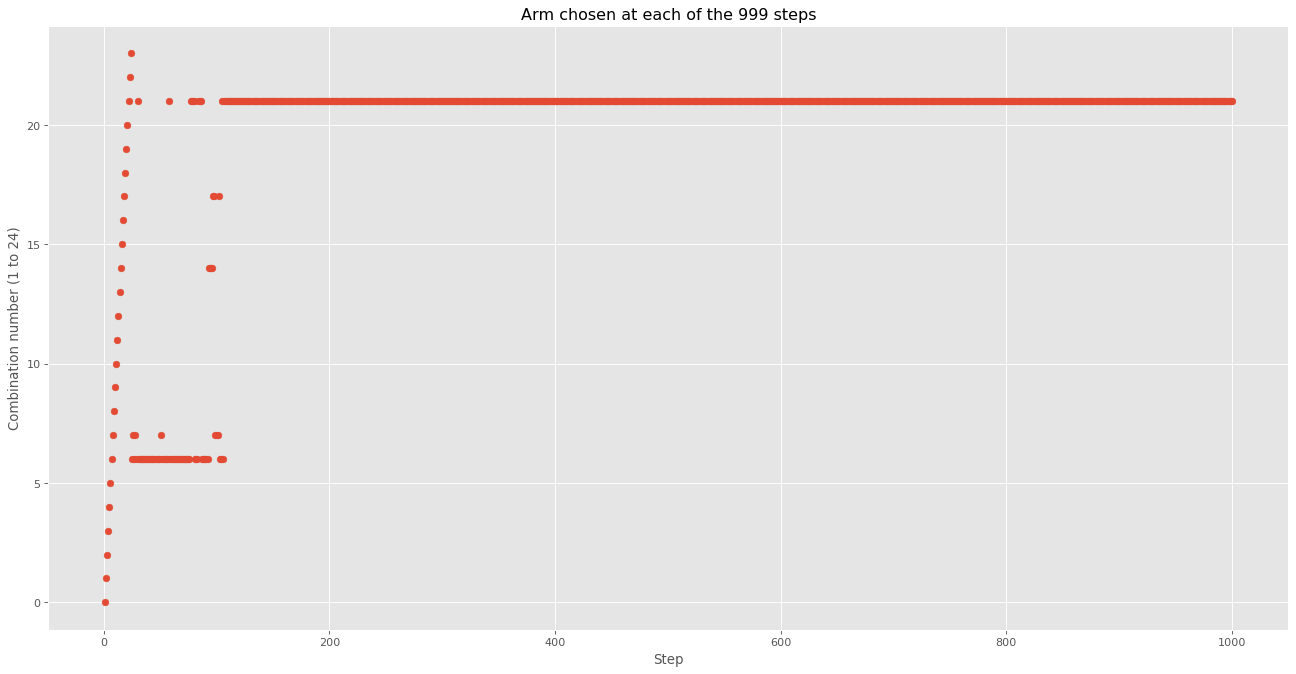

In [18]:
figure(figsize=(20, 10), dpi=80)

plt.scatter(range(1,len(series_of_arms)+1),series_of_arms)
plt.title("Arm chosen at each of the {} steps".format(n))
plt.ylabel('Combination number (1 to 24)')
plt.xlabel('Step')